In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sipm.io.sipm as sipm
import sipm.io.dataset as ds
from scipy.optimize import curve_fit
import ROOT
import sipm.util.functions as func
from numpy.random import normal
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

Welcome to JupyROOT 6.26/06


In [2]:
!pwd

/home/as111/sipm-analysis


# Spectra with different voltages

In [3]:
bias = [63, 65, 67, 69, 71]

In [4]:
ds1120top = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("/scratch/gpfs/as111/root/gamma_1120_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for ch in dset.ch:
        ch.baseline_avg = []
        ch.baseline_std = []
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Top {}V {} events loaded'.format(v, nev))
    ds1120top.append(dset)
    
ds1118top_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("/scratch/gpfs/as111/root/backgrounds_1118_{}V_top.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for ch in dset.ch:
        ch.baseline_avg = []
        ch.baseline_std = []
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Top {}V {} events loaded'.format(v, nev))
    ds1118top_bkg.append(dset)

Top 63V 1003373 events loaded
Top 65V 1007528 events loaded
Top 67V 1016980 events loaded
Top 69V 1014919 events loaded
Top 71V 1015092 events loaded
Top 63V 217218 events loaded
Top 65V 217008 events loaded
Top 67V 218302 events loaded
Top 69V 217576 events loaded
Top 71V 216743 events loaded


## Baseline cut
Same baseline cut as calibration data (baseline std $<2.5$ ADC units). Cut fraction higher.

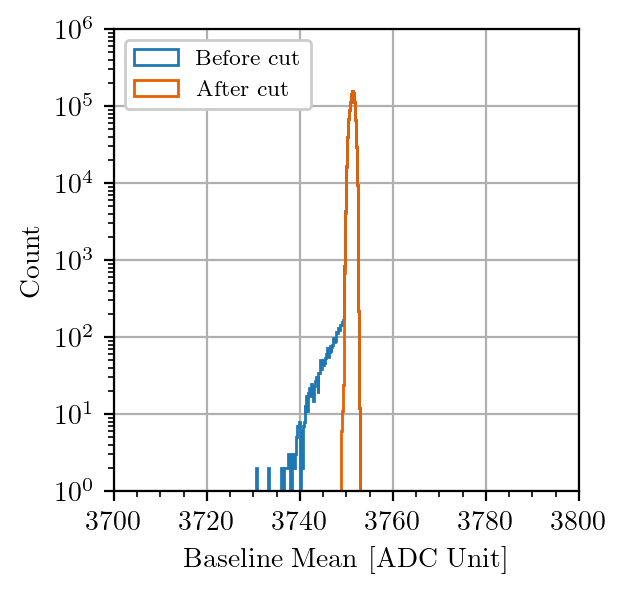

In [5]:
i=1
ch=0
dset = ds1120top[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.figure(0,figsize=(3,3))
plt.hist(dset.baseline_avg, label='Before cut', bins=nbins, range=(range_min, range_max), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=nbins, range=(range_min, range_max), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Unit]')
plt.ylabel('Count')
plt.minorticks_on()
plt.grid()

## Fprompt cut
$F_{\rm prompt}$ is defined as the prompt ($0.5~\rm \mu s$) integral divided by the full ($5~\rm \mu s$) integral.
The ER band of $F_{\rm prompt}\sim0.3$ is clearly visible.
Yet some events have $F_{\rm prompt}\simeq0$, likely due to events triggered on noise with a delayed scintillation pulse.
These are rejected by requiring $F_{\rm prompt}>0.1$.

Text(0, 0.5, '$F_{\\rm prompt}$')

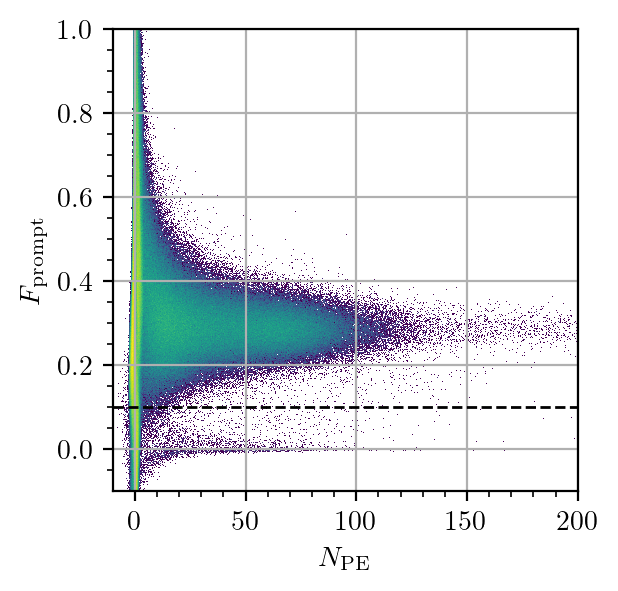

In [6]:
import matplotlib.colors as colors

i=1
dset = ds1120top[i]

nbinsx = 500
range_minx = -10
range_maxx = 200
nbinsy = 500
range_miny = -0.1
range_maxy = 1

fp_cut = 0.1
threshold = 20

plt.figure(0,figsize=(3,3))
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[nbinsx,nbinsy], range=[[range_minx,range_maxx],[range_miny,range_maxy]], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
plt.minorticks_on()
plt.grid()
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')


In [7]:
for i,v in enumerate(bias):
    dset = ds1120top[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118top_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra
The PE count $N_{\rm PE}$ is reconstructed as
$$N_{\rm PE}=\frac{I}{Q_{\rm avg}/(1-p)}=\frac{I}{Q_{\rm peak}(1+Q_{\rm AP})/(1-p)}$$
where $I$ is the time integral ($5~\rm\mu s$) of the unfiltered waveform.
Ideally, this corrects for the direct crosstalk and afterpulsing effects of increasing light yield.

The spectra with source are subtracted by that without source (backgrounds only).
The spectra are normalized with the background sideband ($N_{\rm PE}>170$ for top and $N_{\rm PE}>900$ for bottom).

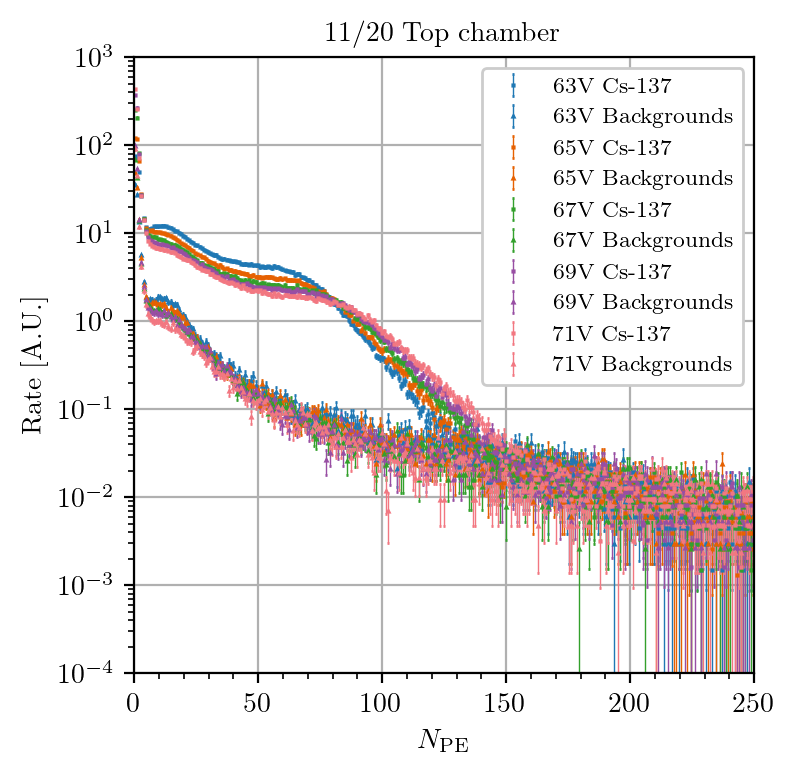

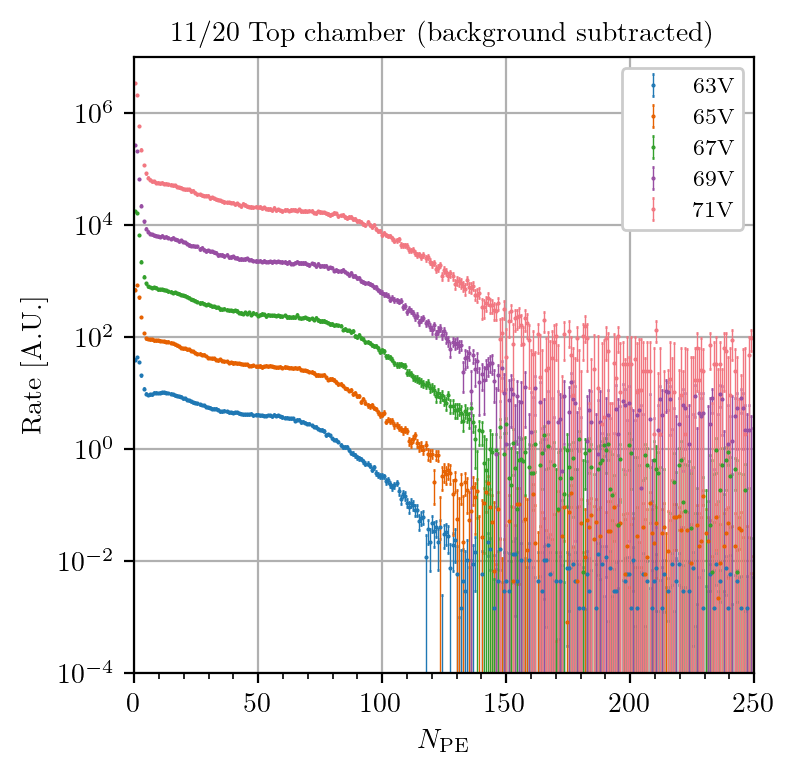

In [10]:
xmin = 0
xmax = 250
nbins = 300
bin_width = (xmax-xmin)/nbins

hist_gamma_top = []
hist_gamma_top_err = []
hist_gamma_top_bins = []
hist_bkg_top = []
hist_bkg_top_err = []
hist_bkg_top_bins = []
hist_dif_top = []
hist_dif_top_err = []
hist_dif_top_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [170, 170, 170, 170, 170]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120top)):
    hg,hgx = np.histogram(ds1120top[i].summed_integral_pe, bins=nbins, range=(xmin,xmax))
    hist_gamma_top_err.append(np.sqrt(hg))
    norm_ = np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hg = hg/norm_
    hist_gamma_top_err[-1] = hist_gamma_top_err[-1]/norm_
    hist_gamma_top.append(hg)
    hist_gamma_top_bins.append(hgx)
    plt.errorbar(0.5*(hgx[1:]+hgx[:-1]), hg, yerr=hist_gamma_top_err[-1], label='{}V {}'.format(bias[i], source[0]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}s'.format(i), markersize=0.5)

    hb,hbx = np.histogram(ds1118top_bkg[i].summed_integral_pe, bins=nbins, range=(xmin,xmax))
    hist_bkg_top_err.append(np.sqrt(hb))
    norm_ = np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hb = hb/norm_
    hist_bkg_top_err[-1] = hist_bkg_top_err[-1]/norm_
    hist_bkg_top.append(hb)
    hist_bkg_top_bins.append(hbx)
    plt.errorbar(0.5*(hbx[1:]+hbx[:-1]), hb, yerr=hist_bkg_top_err[-1], label='{}V {}'.format(bias[i], source[1]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}^'.format(i), markersize=0.5)

plt.yscale('log')
plt.ylabel(r'Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber')
plt.xlim(xmin, xmax)
plt.grid()
plt.minorticks_on()


plt.figure(1,figsize=(4,4))
ymin = 1e-4
ymax = 1e7
hist_dif_top_bins = hist_gamma_top_bins
for i in range(len(hist_gamma_top)):
    hist_dif_top.append(hist_gamma_top[i]-hist_bkg_top[i])
    hist_dif_top_err.append(np.sqrt(hist_gamma_top_err[i]**2 + hist_bkg_top_err[i]**2))
    plt.errorbar(0.5*(hist_dif_top_bins[i][1:]+hist_dif_top_bins[i][:-1]), hist_dif_top[i]*10**i, yerr=hist_dif_top_err[i]*10**i, label='{}V'.format(bias[i]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}o'.format(i), markersize=0.5)
    
plt.yscale('log')
plt.ylabel(r'Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.title('11/20 Top chamber (background subtracted)')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)
plt.grid()
plt.minorticks_on()

# Bottom data 11/20

In [11]:
ds1120bot = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("/scratch/gpfs/as111/root/gamma_1120_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for ch in dset.ch:
        ch.baseline_avg = []
        ch.baseline_std = []
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            
    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1120bot.append(dset)
    
ds1118bot_bkg = []
for i,v in enumerate(bias):
    dset = ds.Dataset(path='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("/scratch/gpfs/as111/root/backgrounds_1118_{}V_bottom.root".format(v), "read")
    tree = file.Get("tree")
    nev = 0
    for ch in dset.ch:
        ch.baseline_avg = []
        ch.baseline_std = []
    for iev, ev in enumerate(tree):
        nev += 1
        cut = True
        for ch in range(4):
            dset.ch[ch].baseline_avg.append(ev.bsl_avg[ch])
            dset.ch[ch].baseline_std.append(ev.bsl_std[ch])
            cut = cut and ev.bsl_std[ch]<2.5
        if cut:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)

    print('Bottom {}V {} events loaded'.format(v, nev))
    ds1118bot_bkg.append(dset)

Bottom 63V 1014166 events loaded
Bottom 65V 1015363 events loaded
Bottom 67V 1015290 events loaded
Bottom 69V 1014591 events loaded
Bottom 71V 1015157 events loaded
Bottom 63V 216580 events loaded
Bottom 65V 216617 events loaded
Bottom 67V 217771 events loaded
Bottom 69V 217350 events loaded
Bottom 71V 218261 events loaded


# Baseline cut

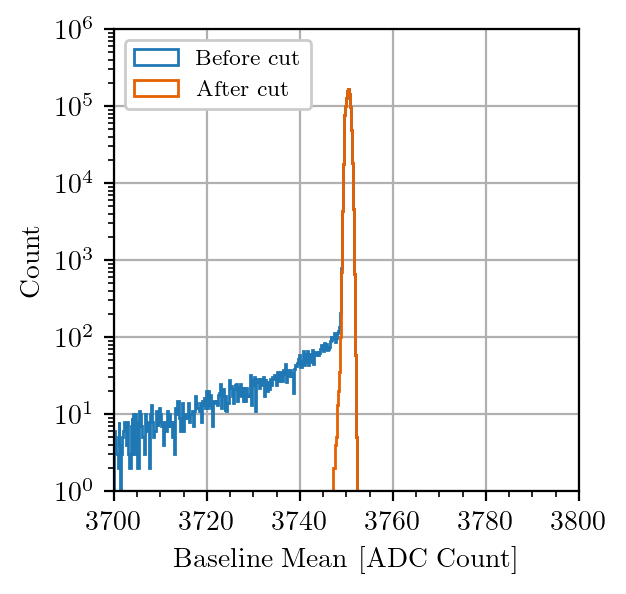

In [12]:
i=1
ch=0
dset = ds1120bot[i].ch[ch]

nbins = 500
range_min = 3700
range_max = 3800
bin_width = (range_max-range_min)/nbins

bsl_avg_cut = []
for ev,avg in enumerate(dset.baseline_avg):
    if dset.baseline_std[ev]<2.5:
        bsl_avg_cut.append(avg)

plt.figure(0,figsize=(3,3))
plt.hist(dset.baseline_avg, label='Before cut', bins=nbins, range=(range_min, range_max), histtype='step')
plt.hist(bsl_avg_cut, label='After cut', bins=nbins, range=(range_min, range_max), histtype='step')
plt.legend()
plt.yscale('log')
plt.xlabel('Baseline Mean [ADC Count]')
plt.ylabel('Count')
plt.grid()
plt.minorticks_on()

# Fprompt cut

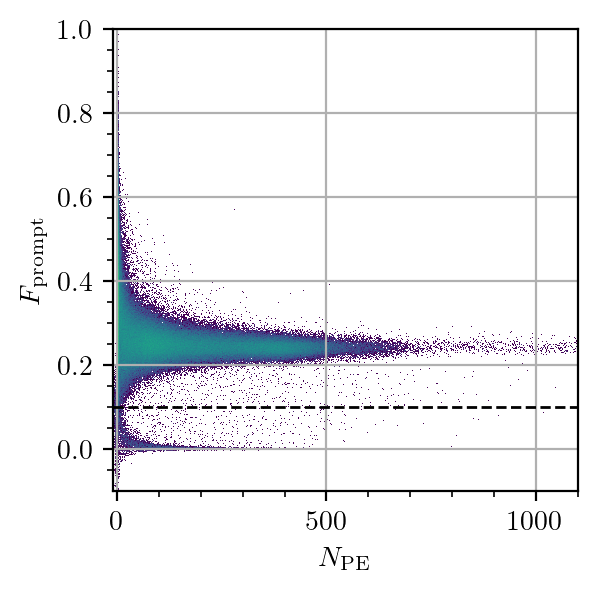

In [14]:
import matplotlib.colors as colors

i=1
dset = ds1120bot[i]

nbinsx = 500
range_minx = -10
range_maxx = 1100
nbinsy = 500
range_miny = -0.1
range_maxy = 1

fp_cut = 0.1

plt.figure(0,figsize=(3,3))
plt.hist2d(dset.summed_integral_pe, dset.fprompt, bins=[nbinsx,nbinsy], range=[[range_minx, range_maxx],[range_miny, range_maxy]], norm = colors.LogNorm())
plt.plot([range_minx, range_maxx], [fp_cut]*2, 'k--', linewidth=1)
plt.xlabel(r'$N_{\rm PE}$')
plt.ylabel(r'$F_{\rm prompt}$')
plt.grid()
plt.minorticks_on()

In [15]:
for i,v in enumerate(bias):
    dset = ds1120bot[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut

    dset = ds1118bot_bkg[i]
    pe_cut = []
    for ev,fp in enumerate(dset.fprompt):
        if fp>fp_cut:
            pe_cut.append(dset.summed_integral_pe[ev])
    dset.summed_integral_pe = pe_cut


## Draw spectra

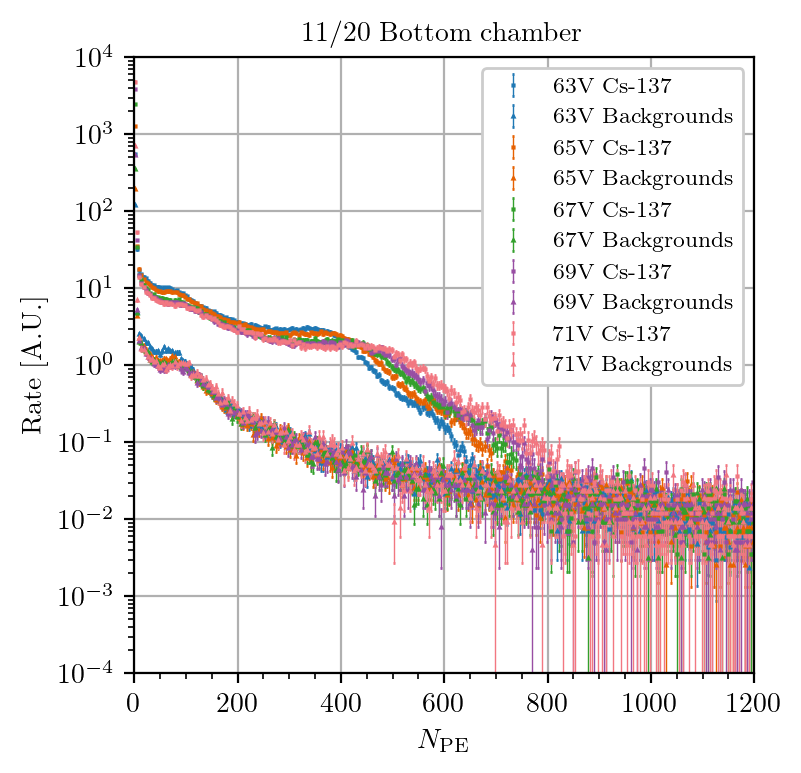

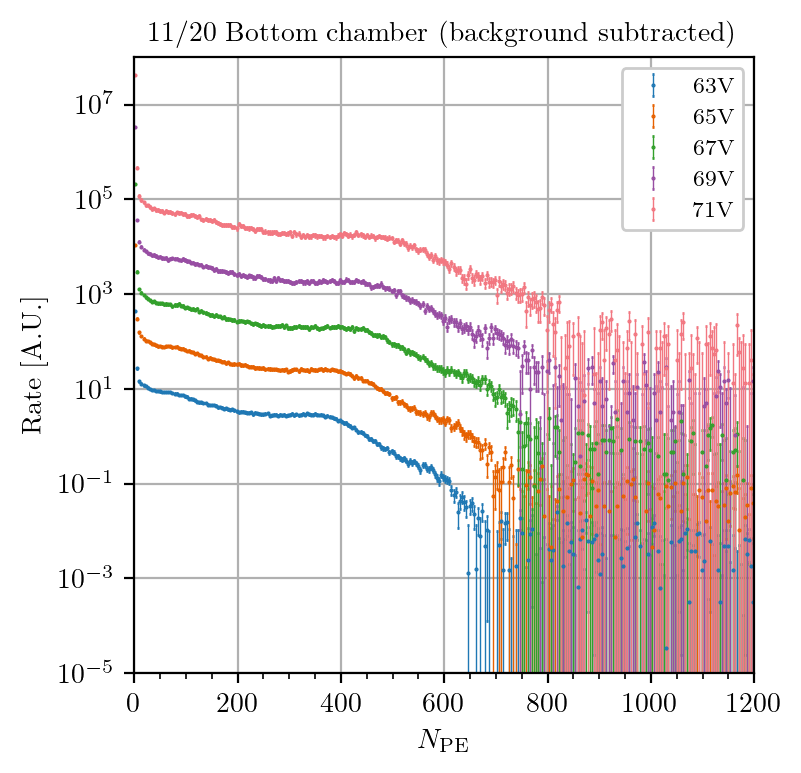

In [18]:
xmin = 0
xmax = 1200
nbins = 300
bin_width = (xmax-xmin)/nbins

hist_gamma_bot = []
hist_gamma_bot_err = []
hist_gamma_bot_bins = []
hist_bkg_bot = []
hist_bkg_bot_err = []
hist_bkg_bot_bins = []
hist_dif_bot = []
hist_dif_bot_err = []
hist_dif_bot_bins = []
source = ['Cs-137', 'Backgrounds']
color = ['r', 'g']
bkg_boundary = [900, 900, 900, 900, 900]
# scale = [3.3, 2.2, 1.7, 1.3, 1]
plt.figure(0,figsize=(4,4))
for i in range(len(ds1120bot)):
    hg,hgx = np.histogram(ds1120bot[i].summed_integral_pe, bins=nbins, range=(xmin,xmax))
    hist_gamma_bot_err.append(np.sqrt(hg))
    # hg = hg/dset.ch[0].cumulative_time/bin_width
    norm_ = np.sum(hg[int((bkg_boundary[i]-xmin)/bin_width):])
    hg = hg/norm_
    hist_gamma_bot_err[i] = hist_gamma_bot_err[i]/norm_
    hist_gamma_bot.append(hg)
    hist_gamma_bot_bins.append(hgx)
    plt.errorbar(0.5*(hgx[1:]+hgx[:-1]), hg, yerr=hist_gamma_bot_err[-1], label='{}V {}'.format(bias[i], source[0]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}s'.format(i), markersize=0.5)

    hb,hbx = np.histogram(ds1118bot_bkg[i].summed_integral_pe, bins=nbins, range=(xmin,xmax))
    hist_bkg_bot_err.append(np.sqrt(hb))
    norm_ = np.sum(hb[int((bkg_boundary[i]-xmin)/bin_width):])
    hb = hb/norm_
    hist_bkg_bot_err[i] = hist_bkg_bot_err[i]/norm_
    hist_bkg_bot.append(hb)
    hist_bkg_bot_bins.append(hbx)
    plt.errorbar(0.5*(hbx[1:]+hbx[:-1]), hb, yerr=hist_bkg_bot_err[-1], label='{}V {}'.format(bias[i], source[1]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}^'.format(i), markersize=0.5)

plt.yscale('log')
plt.ylabel(r'Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber')
plt.xlim(xmin, xmax)
plt.grid()
plt.minorticks_on()

plt.figure(1,figsize=(4,4))
hist_dif_bot_bins = hist_gamma_bot_bins
for i in range(len(hist_gamma_bot)):
    hist_dif_bot.append(hist_gamma_bot[i]-hist_bkg_bot[i])
    hist_dif_bot_err.append(np.sqrt(hist_gamma_bot_err[i]**2 + hist_bkg_bot_err[i]**2))
    plt.errorbar(0.5*(hist_dif_bot_bins[i][1:]+hist_dif_bot_bins[i][:-1]), hist_dif_bot[i]*10**i, yerr=hist_dif_bot_err[i]*10**i, label='{}V'.format(bias[i]), ls='none', capsize=0.5, elinewidth=0.5, fmt='C{}o'.format(i), markersize=0.5)
    
plt.yscale('log')
plt.ylabel(r'Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.title('11/20 Bottom chamber (background subtracted)')
plt.xlim(xmin, xmax)
plt.grid()
plt.minorticks_on()

## Read DiCT probability from csv file

In [19]:
import csv
p_dict_top = []
p_dict_bot = []
syserr2_top = [0]*5
syserr2_bot = [0]*5
for i,volt in enumerate(bias):
    with open('data/calibration/calibration_1122_{}V.csv'.format(volt)) as f:
        r = csv.reader(f)
        p_top = 0
        p_bot = 0
        line_count = 0
        for row in r:
            if line_count>0:
                if line_count<=4:
                    p_top += float(row[3])
                    syserr2_top[i] += (float(row[6])/float(row[5]))**2 + (float(row[4])/(1-float(row[3])))**2
                else:
                    p_bot += float(row[3])
                    syserr2_bot[i] += (float(row[6])/float(row[5]))**2 + (float(row[4])/(1-float(row[3])))**2
            line_count += 1
        p_top /= 4
        p_bot /= 4
        p_dict_top.append(p_top)
        p_dict_bot.append(p_bot)
print('DiCT probability:')
print(p_dict_top)
print(p_dict_bot)
print('Systematics from calibration:')
print('Top {}'.format(np.sqrt(syserr2_top)))
print('Bottom {}'.format(np.sqrt(syserr2_bot)))

DiCT probability:
[0.13268974329597602, 0.18223594279924585, 0.23694935070957202, 0.2925180209273492, 0.3470491939075766]
[0.11306638888195386, 0.16154671478460234, 0.2106152065654187, 0.2643300388539115, 0.318856644748837]
Systematics from calibration:
Top [0.00835405 0.00840437 0.01044748 0.01704478 0.02285045]
Bottom [0.0091259  0.0128004  0.0164943  0.01891367 0.02200683]


## Detector response model
Consider light yield non-uniformity. Let $\alpha$ be the relative RMS variation:
$$L'_y \sim \mathcal{N}(\mu = L_y, \sigma=\alpha L_y)$$
Fix Fano factor to $1+p$ derived from compound Poisson distribution. The $(1-p)^2$ factor is canceled out due to the DiCT correction in PE reconstruction.
This Fano factor accounts for photon transport and direct crosstalk effects.
$$N_{\rm PE} \sim \mathcal{N}(\mu=L'_y E_{\rm dep}, \sigma=\sqrt{(1+p)L'_y E_{\rm dep}})$$

In [35]:
def chisquare_two_hist_new(ly, alpha, data_hist, data_hist_bins, data_hist_err, tree, p_dict, range_pe):
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
    simulated_pe = []
    for i,ev in enumerate(tree):
        lyr = normal(ly, ly*alpha)
        simulated_pe.append(normal(lyr*ev.Edep, np.sqrt((1+p_dict)*lyr*ev.Edep)))
    hSimPE, hSimPE_bins = np.histogram(simulated_pe, bins=nbins, range=(xmin,xmax))
    hSimPE_err = np.sqrt(hSimPE)
    simulated_pe = []
    range_bin = [int((range_pe[0]-xmin)/bin_width), int((range_pe[1]-xmin)/bin_width)]
    norm_sim = np.sum(data_hist[range_bin[0]:range_bin[1]])/np.sum(hSimPE[range_bin[0]:range_bin[1]])
    hSimPE = hSimPE*norm_sim
    hSimPE_err = hSimPE_err*norm_sim
    chi_square = 0
    for i in range(range_bin[0], range_bin[1]):
        chi_square += (data_hist[i] - hSimPE[i])**2/((data_hist_err[i])**2 + (hSimPE_err[i])**2)
    dof = range_bin[1]-range_bin[0] - 4
    return chi_square

# Chi-square map
Light yield $L_y$ and non-uniformity $\alpha$ are the fit parameters.
The simulated spectrum is generated for each ($L_y$,$\alpha$) combination.
The $\chi^2$ maps have statistical noises, so it is impossible to fit using a minimizer.
Instead, we fit the $\chi^2$ maps with $-2\ln\mathcal{L}$, where $\mathcal{L}$ is bivariate Gaussian distribution.
The best-fit parameters and the covariance matrix are obtained from $\mathcal{L}$
For interval estimation, 68% CL in 2D corresponds to 1.515 $\sigma$.

In [36]:
from scipy.stats import multivariate_normal
from scipy.stats import norm

def gauss2d(xy, ly, fano, Sx, Sy, theta, c):
    sxx = Sx**2*np.cos(theta)**2+Sy**2*np.sin(theta)**2
    sxy = (Sx**2-Sy**2)*np.sin(theta)*np.cos(theta)
    syy = Sx**2*np.sin(theta)**2+Sy**2*np.cos(theta)**2
    return -2*np.log(2*np.pi*Sx*Sy*multivariate_normal(mean=[ly,fano], cov=[[sxx, sxy],[sxy, syy]]).pdf(xy))+c

## Top

Running for top 63V
Ly=0.147+/-0.001 PE/keV  alpha=0.066+/-0.012 (68% CL)
174324 events simulated
Running for top 65V
Ly=0.159+/-0.001 PE/keV  alpha=0.055+/-0.014 (68% CL)
174324 events simulated
Running for top 67V
Ly=0.170+/-0.001 PE/keV  alpha=0.062+/-0.012 (68% CL)
174324 events simulated
Running for top 69V
Ly=0.176+/-0.001 PE/keV  alpha=0.064+/-0.014 (68% CL)
174324 events simulated
Running for top 71V
Ly=0.187+/-0.001 PE/keV  alpha=0.069+/-0.013 (68% CL)
174324 events simulated
[[0.1474923568013237, 0.0006418825283346816], [0.15917313035089878, 0.0007981829777803072], [0.16978920107521736, 0.0007694137704644588], [0.17611173956371423, 0.0008382429495063264], [0.18661930738649435, 0.0007605061646225276]]
[[0.06611170520311897, 0.012046238981877443], [0.0553224309657401, 0.014361781642009151], [0.06192243075558484, 0.012124217533578665], [0.06385973873715067, 0.013677129767430974], [0.0686285114921453, 0.013317049799870586]]


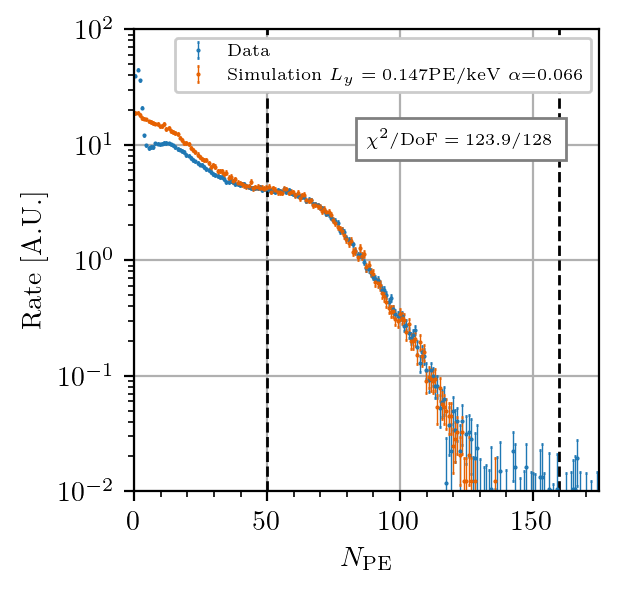

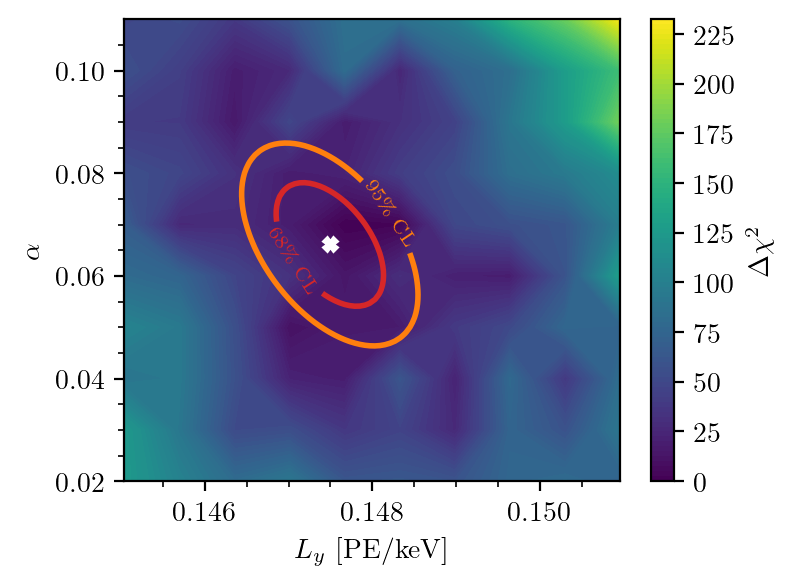

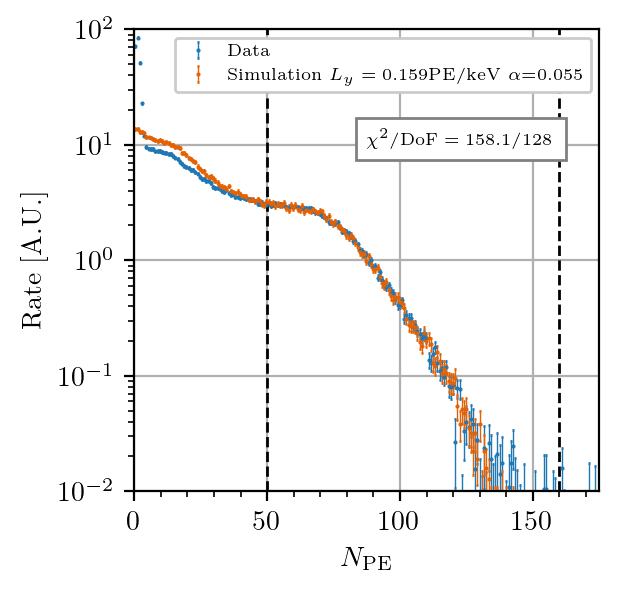

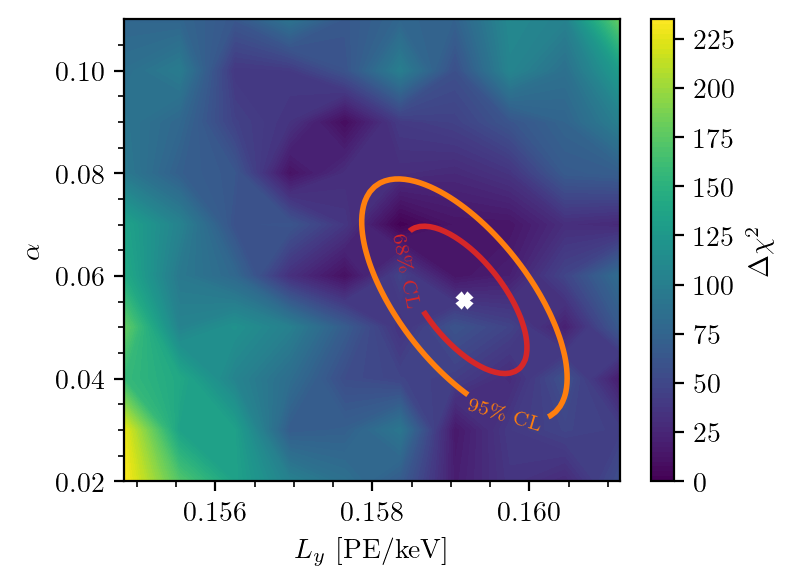

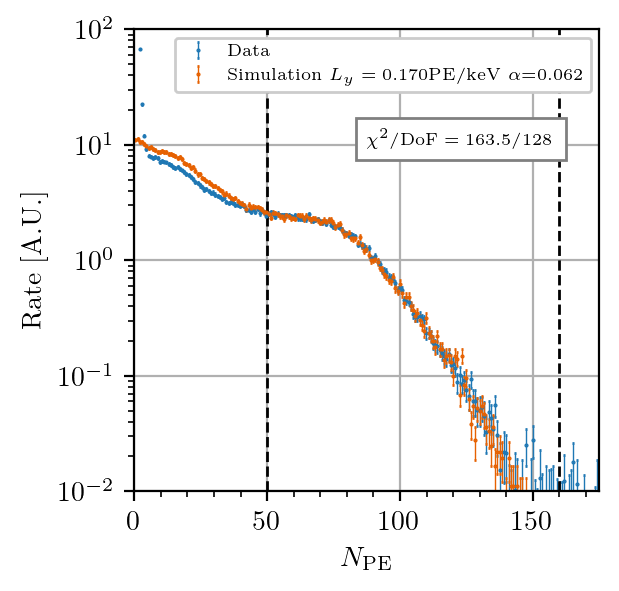

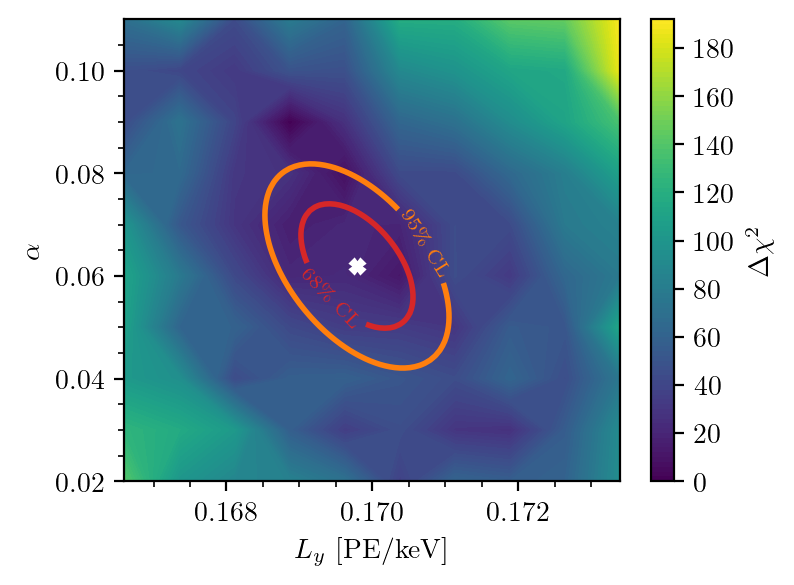

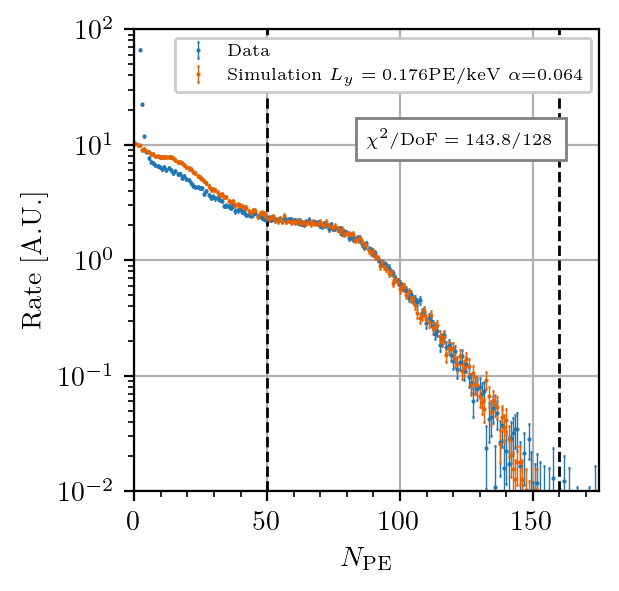

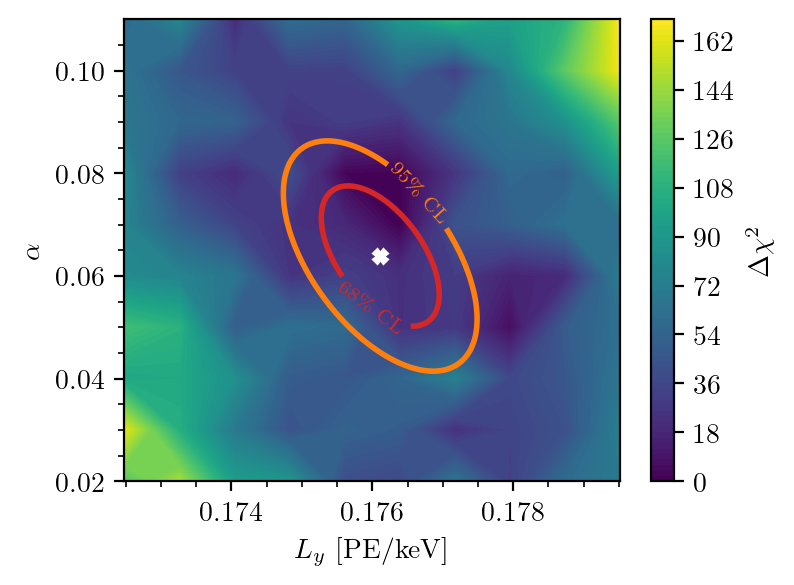

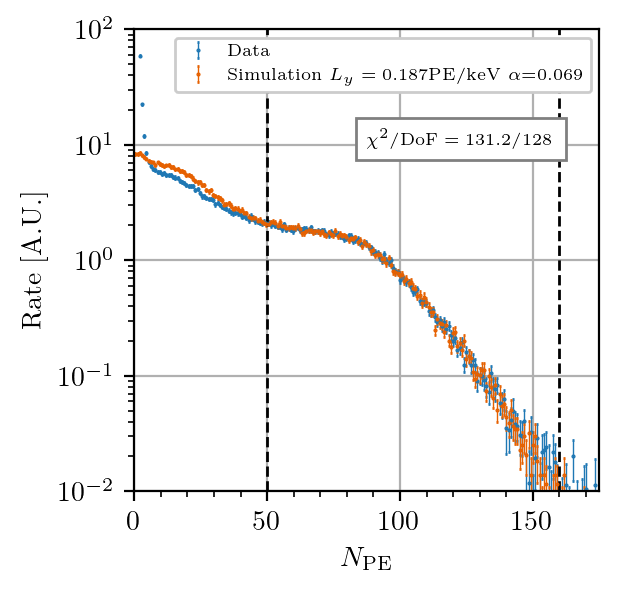

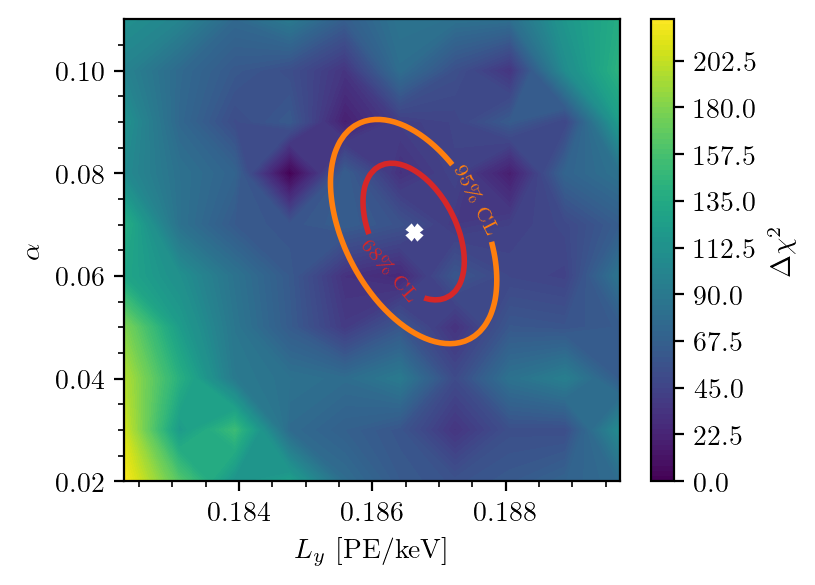

In [37]:
ly_guess = [0.148, 0.158, 0.170, 0.176, 0.186]
ly_top = []
alpha_top = []
for iv,volt in enumerate(bias):
    print('Running for top {}V'.format(volt))
    data_hist = hist_dif_top[iv]
    data_hist_bins = hist_dif_top_bins[iv]
    data_hist_err = hist_dif_top_err[iv]

    file = ROOT.TFile("/scratch/gpfs/as111/root/pu_lar_cs137_Edep.root", "read")
    tr = file.Get("trEdep")

    lys = np.linspace(ly_guess[iv]*0.98, ly_guess[iv]*1.02, 10)
    alphas = np.linspace(0.02, 0.11, 10)
    X,Y = np.meshgrid(lys, alphas)

    # Spectrum fit range
    norm_min = 50
    norm_max = 160
    chi2map = np.array([[chisquare_two_hist_new(ly_, alpha_, data_hist, data_hist_bins, data_hist_err, tr, p_dict_top[iv], [norm_min,norm_max]) for ly_ in lys] for alpha_ in alphas])
    min_chi2 = np.min(chi2map)
    chi2map = chi2map - min_chi2

    # Fit chi-square to find minimum and errors
    popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[ly_guess[iv], 0.08, 0.002, 0.006, 0.2, 150], maxfev=10000)

    # Print best fit values and 68% CL
    ly_fit = popt[0]
    alpha_fit = popt[1]
    ly_68 = func.error_distance(df=2,sigma=1)*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
    alpha_68 = func.error_distance(df=2,sigma=1)*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
    print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
    ly_top.append([ly_fit, ly_68])
    alpha_top.append([alpha_fit, alpha_68])
    
    simPE = []
    nev = 0
    for i,ev in enumerate(tr):
        for j in range(1):
            ly_random = normal(loc=ly_fit,scale=ly_fit*alpha_fit) 
            simPE.append(normal(ly_random*tr.Edep, np.sqrt((1+p_dict_top[iv])*ly_random*tr.Edep)))
            nev += 1
    print('{} events simulated'.format(nev))
    file.Close()

    ymin = 1e-2
    ymax = 1e2
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
    hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
    hSimErr = np.sqrt(hSim)
    norm_ = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    hSim = hSim*norm_
    hSimErr = hSimErr*norm_
    chi2_inplot = np.sum(((hSim-data_hist)**2/(hSimErr**2 + data_hist_err**2))[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    plt.figure(iv,figsize=(3,3))
    plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(ly_fit, alpha_fit), fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
    plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
    plt.text(xmax*0.7*0.5, ymax/10, r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(chi2_inplot,(norm_max-norm_min)/bin_width-4), fontsize=6,bbox=dict(facecolor='white',edgecolor='grey',alpha=1))
    plt.grid()
    plt.minorticks_on()
    plt.yscale('log')
    plt.ylabel('Rate [A.U.]')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.legend(loc='upper right', fontsize=6)
    plt.xlim(xmin, xmax*0.7)
    plt.ylim(ymin, ymax)

    # (Ly,F) range
    XX,YY = np.meshgrid(np.linspace(lys[0],lys[-1],100),np.linspace(alphas[0],alphas[-1],100))
    plt.figure(iv+10,figsize=(4,3))
    plt.contourf(X,Y,chi2map,100)
    plt.colorbar(label=r'$\Delta\chi^2$')
    cs = plt.contour(XX,YY,gauss2d(np.dstack((XX,YY)),*popt),[popt[5]-2*np.log(2*(1-norm.cdf(1,0,1))), popt[5]-2*np.log(2*(1-norm.cdf(2,0,1)))], colors=['tab:red', 'tab:orange'])
    plt.clabel(cs, fmt={cs.levels[0]:'68\% CL', cs.levels[1]:'95\% CL'},fontsize=7)
    plt.plot([ly_fit],[alpha_fit],'wX', markersize=5)
    plt.xlabel(r'$L_y$ [PE/keV]')
    plt.ylabel(r'$\alpha$')
    plt.minorticks_on()

print(ly_top)
print(alpha_top)

Text(0.5, 0.98, 'Top')

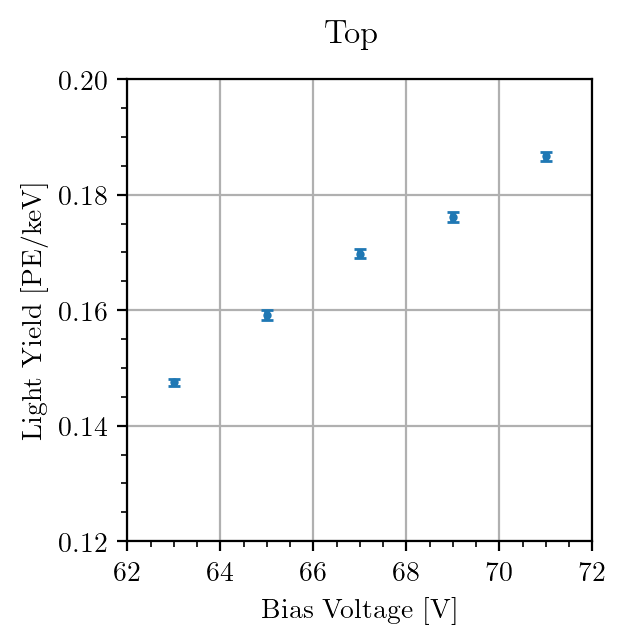

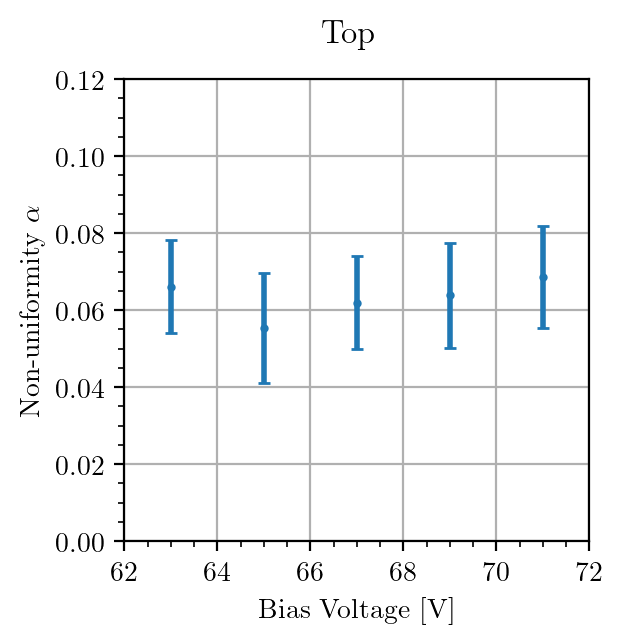

In [38]:
plt.figure(0,figsize=(3,3))
plt.errorbar(bias,np.array(ly_top)[:,0],yerr=np.array(ly_top)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Light Yield [PE/keV]')
plt.xlim(62,72)
plt.ylim(0.12,0.2)
plt.suptitle('Top')

plt.figure(1,figsize=(3,3))
plt.errorbar(bias,np.array(alpha_top)[:,0],yerr=np.array(alpha_top)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Non-uniformity $\alpha$')
plt.xlim(62,72)
plt.ylim(0,0.12)
plt.suptitle('Top')

## Bottom

Running for bottom 63V
Ly=0.832+/-0.003 PE/keV  alpha=0.080+/-0.006 (68% CL)
174324 events simulated
Running for bottom 65V
Ly=0.894+/-0.003 PE/keV  alpha=0.084+/-0.006 (68% CL)
174324 events simulated
Running for bottom 67V
Ly=0.968+/-0.004 PE/keV  alpha=0.078+/-0.007 (68% CL)
174324 events simulated
Running for bottom 69V
Ly=1.015+/-0.005 PE/keV  alpha=0.080+/-0.008 (68% CL)
174324 events simulated
Running for bottom 71V
Ly=1.071+/-0.006 PE/keV  alpha=0.071+/-0.008 (68% CL)
174324 events simulated
[[0.8316529677973629, 0.002648506602655074], [0.8942769235334904, 0.0032005605955280547], [0.9681443786081402, 0.004160496176843803], [1.0153162015708477, 0.004987189780883345], [1.0712379403746786, 0.005718021480229575]]
[[0.07985126229843531, 0.005720966686893194], [0.08363035238217127, 0.005934922498213736], [0.07779123462921614, 0.0071674155577774856], [0.07976425249999634, 0.00793249088578467], [0.071339232009347, 0.00779956195721571]]


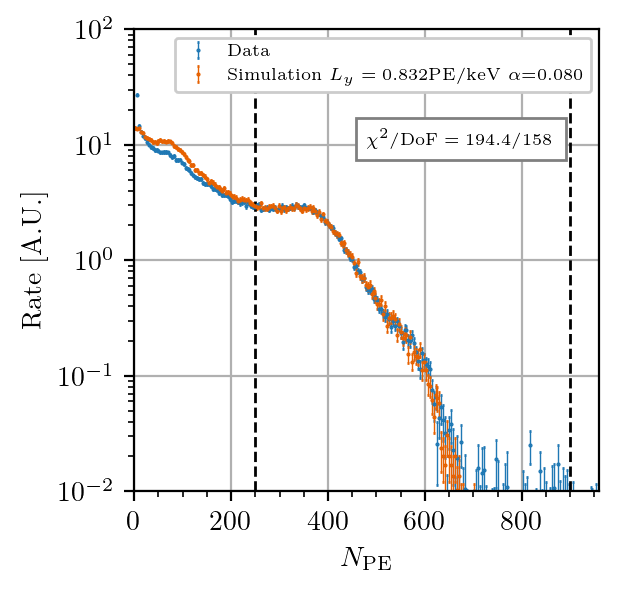

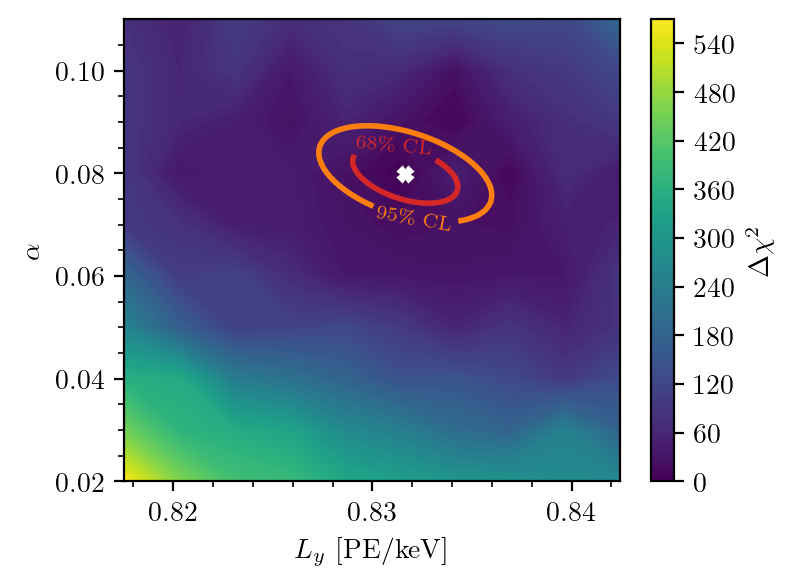

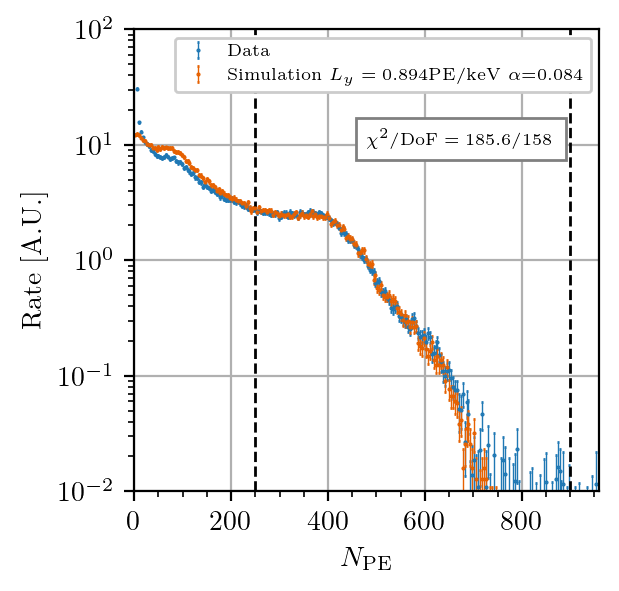

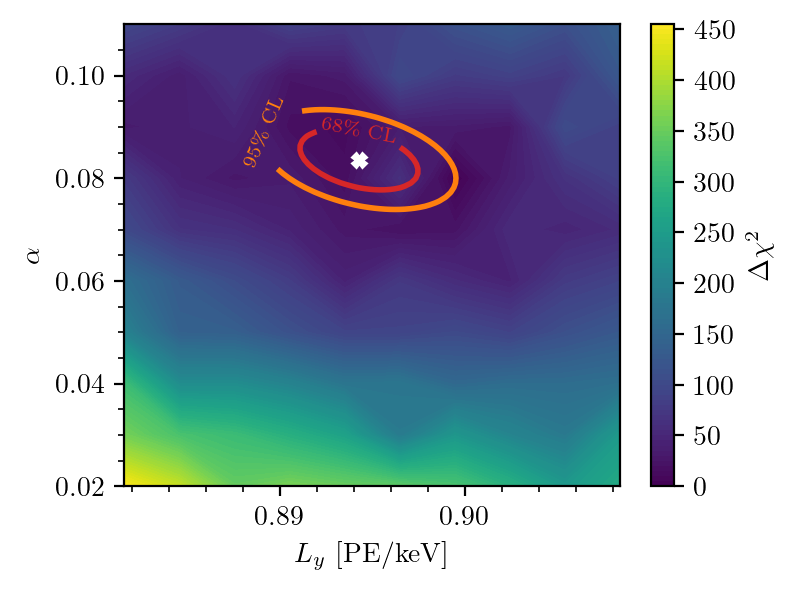

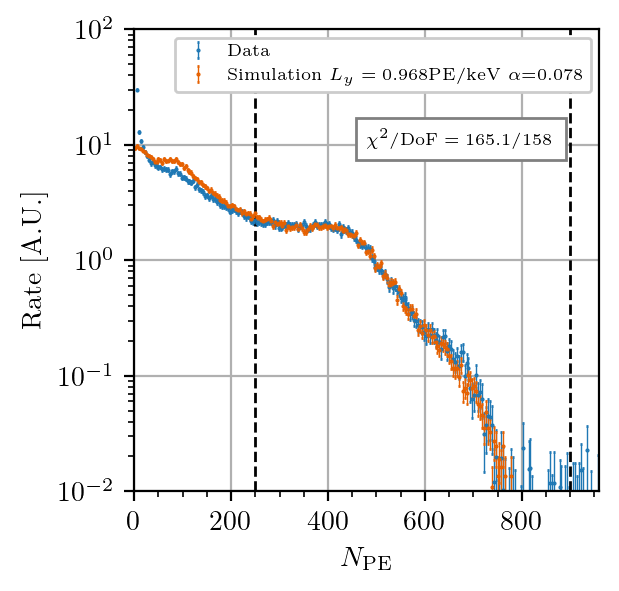

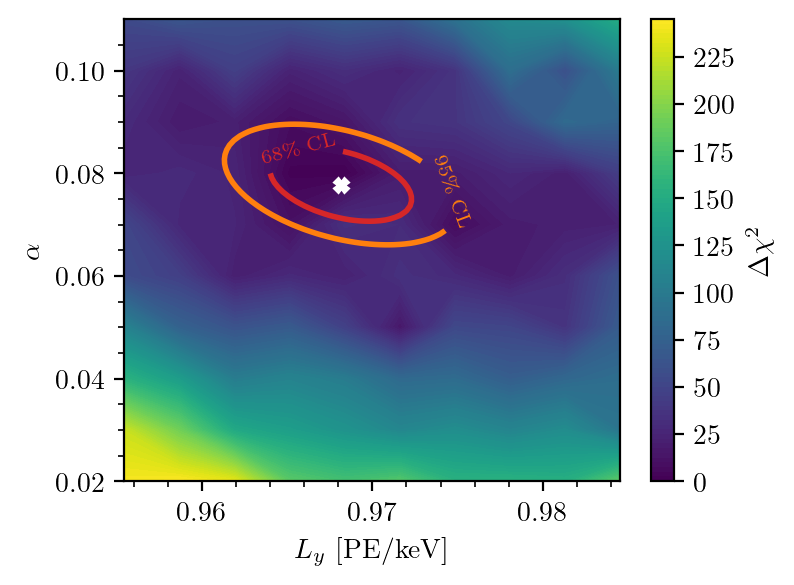

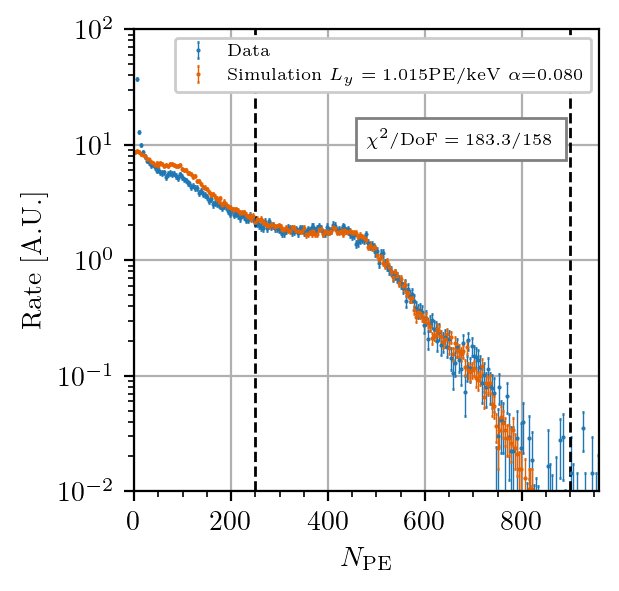

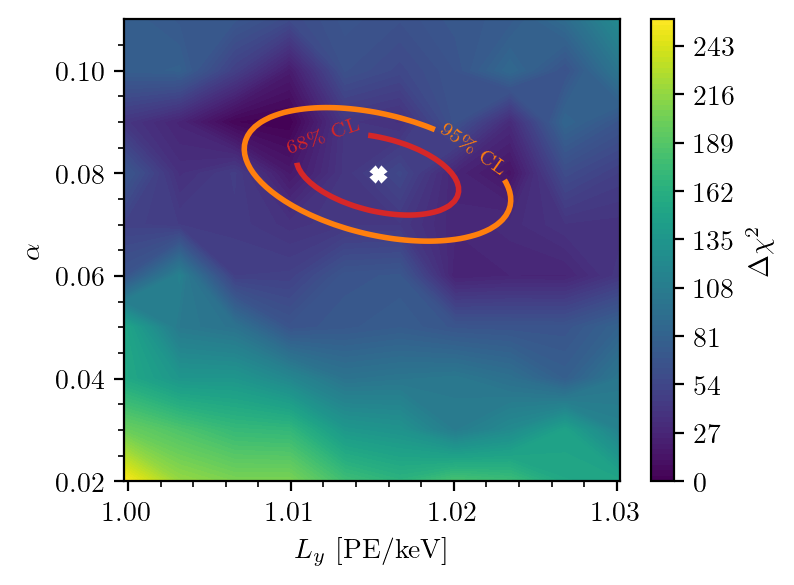

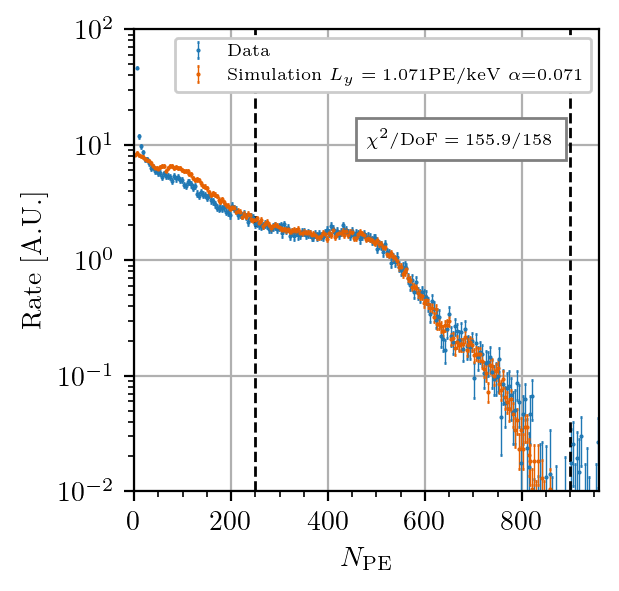

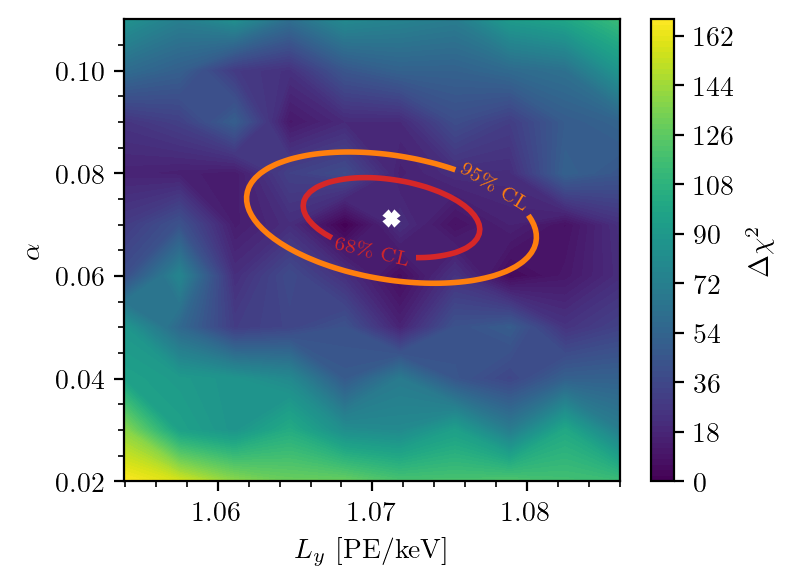

In [39]:
ly_guess = [0.83, 0.895, 0.97, 1.015, 1.07]
ly_bot = []
alpha_bot = []
for iv,volt in enumerate(bias):
    print('Running for bottom {}V'.format(volt))
    data_hist = hist_dif_bot[iv]
    data_hist_bins = hist_dif_bot_bins[iv]
    data_hist_err = hist_dif_bot_err[iv]

    file = ROOT.TFile("/scratch/gpfs/as111/root/pu_lar_cs137_Edep.root", "read")
    tr = file.Get("trEdep")

    lys = np.linspace(ly_guess[iv]*0.985, ly_guess[iv]*1.015, 10)
    alphas = np.linspace(0.02, 0.11, 10)
    X,Y = np.meshgrid(lys, alphas)

    # Spectrum fit range
    norm_min = 250
    norm_max = 900
    chi2map = np.array([[chisquare_two_hist_new(ly_, alpha_, data_hist, data_hist_bins, data_hist_err, tr, p_dict_bot[iv], [norm_min,norm_max]) for ly_ in lys] for alpha_ in alphas])
    min_chi2 = np.min(chi2map)
    chi2map = chi2map - min_chi2

    # Fit chi-square to find minimum and errors
    popt,pcov = curve_fit(gauss2d, np.stack((X, Y),axis=-1).reshape(-1,2), chi2map.flatten(), p0=[ly_guess[iv], 0.08, 0.002, 0.006, 0.2, 150], maxfev=10000)

    # Print best fit values and 68% CL
    ly_fit = popt[0]
    alpha_fit = popt[1]
    ly_68 = func.error_distance(df=2,sigma=1)*np.sqrt(popt[2]**2*np.cos(popt[4])**2+popt[3]**2*np.sin(popt[4])**2)
    alpha_68 = func.error_distance(df=2,sigma=1)*np.sqrt(popt[2]**2*np.sin(popt[4])**2+popt[3]**2*np.cos(popt[4])**2)
    print('Ly={:.3f}+/-{:.3f} PE/keV  alpha={:.3f}+/-{:.3f} (68% CL)'.format(ly_fit, ly_68, alpha_fit, alpha_68))
    ly_bot.append([ly_fit, ly_68])
    alpha_bot.append([alpha_fit, alpha_68])
    
    simPE = []
    nev = 0
    for i,ev in enumerate(tr):
        for j in range(1):
            ly_random = normal(loc=ly_fit,scale=ly_fit*alpha_fit) 
            simPE.append(normal(ly_random*tr.Edep, np.sqrt((1+p_dict_bot[iv])*ly_random*tr.Edep)))
            nev += 1
    print('{} events simulated'.format(nev))
    file.Close()

    ymin = 1e-2
    ymax = 1e2
    xmin = data_hist_bins[0]
    xmax = data_hist_bins[-1]
    nbins = len(data_hist_bins)-1
    bin_width = (xmax-xmin)/nbins
    hSim, hSim_bins = np.histogram(simPE, bins=np.linspace(xmin,xmax,nbins+1))
    hSimErr = np.sqrt(hSim)
    norm_ = np.sum(data_hist[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])/np.sum(hSim[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    hSim = hSim*norm_
    hSimErr = hSimErr*norm_
    chi2_inplot = np.sum(((hSim-data_hist)**2/(hSimErr**2 + data_hist_err**2))[int((norm_min-xmin)/bin_width):int((norm_max-xmin)/bin_width)])
    plt.figure(iv,figsize=(3,3))
    plt.errorbar(0.5*(data_hist_bins[1:]+data_hist_bins[:-1]), data_hist, yerr=data_hist_err, fmt='o', label='Data', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.errorbar(0.5*(hSim_bins[1:]+hSim_bins[:-1]), hSim, yerr=hSimErr, label=r'Simulation $L_y={:.3f}$PE/keV $\alpha$={:.3f}'.format(ly_fit, alpha_fit), fmt='o', ls='none', capsize=0.5, elinewidth=0.5, markersize=0.5)
    plt.plot([norm_min, norm_min], [ymin, ymax], 'k--', linewidth=1)
    plt.plot([norm_max, norm_max], [ymin, ymax], 'k--', linewidth=1)
    plt.text(xmax*0.8*0.5, ymax/10, r'$\chi^2/\rm DoF={:.1f}/{:.0f}$'.format(chi2_inplot,(norm_max-norm_min)/bin_width-4), fontsize=6,bbox=dict(facecolor='white',edgecolor='grey',alpha=1))
    plt.grid()
    plt.minorticks_on()
    plt.yscale('log')
    plt.ylabel('Rate [A.U.]')
    plt.xlabel(r'$N_{\rm PE}$')
    plt.legend(loc='upper right', fontsize=6)
    plt.xlim(xmin, xmax*0.8)
    plt.ylim(ymin, ymax)

    # (Ly,F) range
    XX,YY = np.meshgrid(np.linspace(lys[0],lys[-1],100),np.linspace(alphas[0],alphas[-1],100))
    plt.figure(iv+10,figsize=(4,3))
    plt.contourf(X,Y,chi2map,100)
    plt.colorbar(label=r'$\Delta\chi^2$')
    cs = plt.contour(XX,YY,gauss2d(np.dstack((XX,YY)),*popt),[popt[5]-2*np.log(2*(1-norm.cdf(1,0,1))), popt[5]-2*np.log(2*(1-norm.cdf(2,0,1)))], colors=['tab:red', 'tab:orange'])
    plt.clabel(cs, fmt={cs.levels[0]:'68\% CL', cs.levels[1]:'95\% CL'},fontsize=7)
    plt.plot([ly_fit],[alpha_fit],'wX', markersize=5)
    plt.xlabel(r'$L_y$ [PE/keV]')
    plt.ylabel(r'$\alpha$')
    plt.minorticks_on()

print(ly_bot)
print(alpha_bot)

Text(0.5, 0.98, 'Bottom')

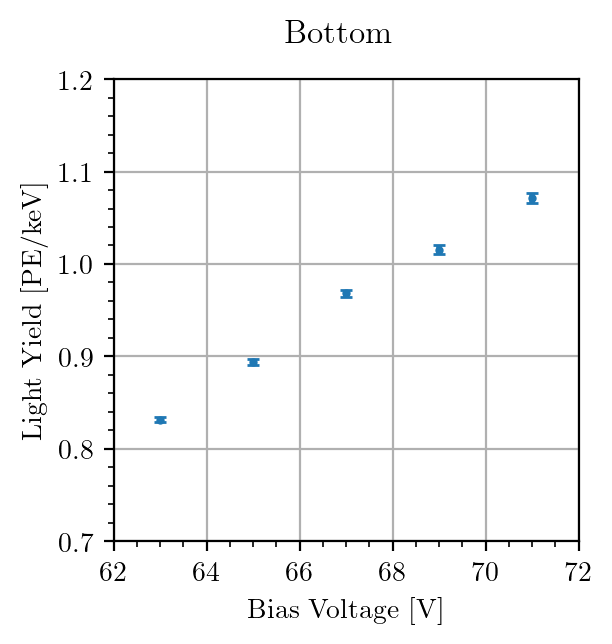

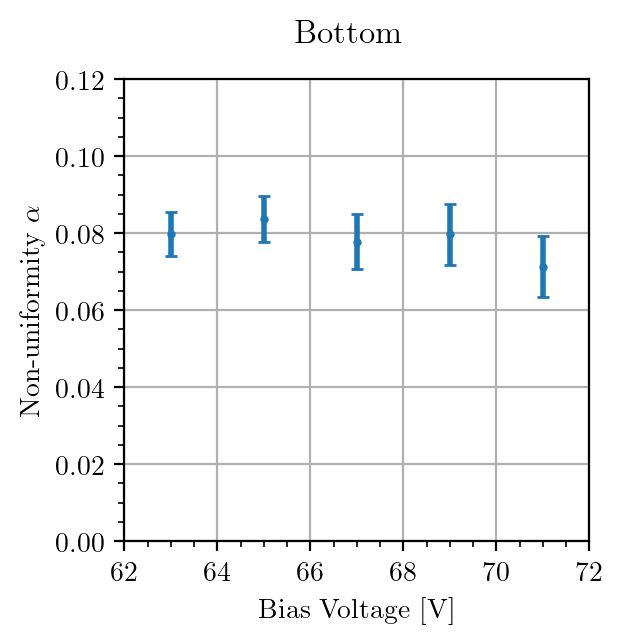

In [40]:
plt.figure(0,figsize=(3,3))
plt.errorbar(bias,np.array(ly_bot)[:,0],yerr=np.array(ly_bot)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Light Yield [PE/keV]')
plt.xlim(62,72)
plt.ylim(0.7,1.2)
plt.suptitle('Bottom')

plt.figure(1,figsize=(3,3))
plt.errorbar(bias,np.array(alpha_bot)[:,0],yerr=np.array(alpha_bot)[:,1], fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.grid()
plt.minorticks_on()
plt.xlabel(r'Bias Voltage [V]')
plt.ylabel(r'Non-uniformity $\alpha$')
plt.xlim(62,72)
plt.ylim(0,0.12)
plt.suptitle('Bottom')

## Top-Bottom Comparison
The error bars for light yield (ratio) here include the contribution from calibration (SPE gain and DiCT probability)

Average Tyvek-to-ESR Ly ratio = 0.1765+/-0.0015
max-min/2 = 0.0023
max-min/2/avg = 1.28%


(0.0, 0.14)

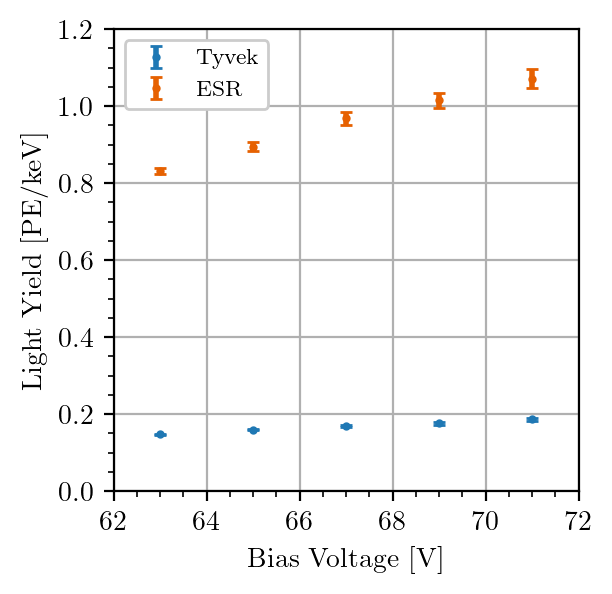

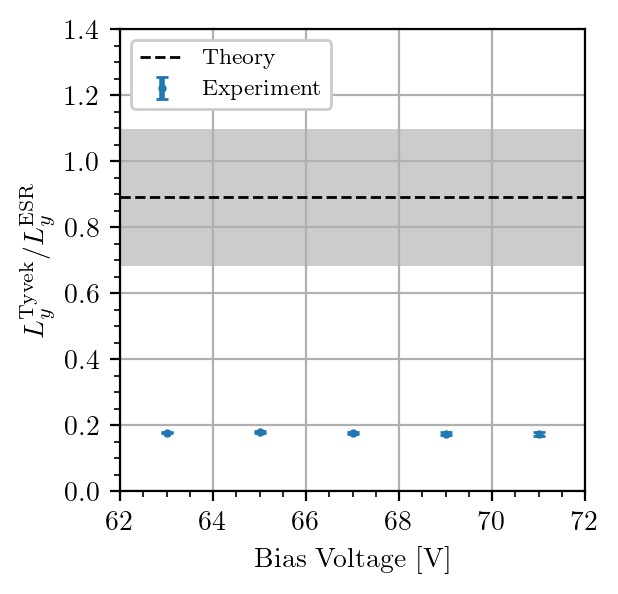

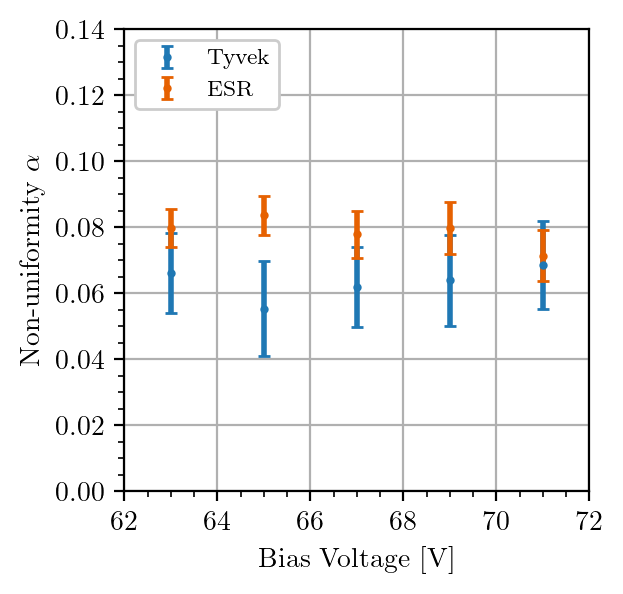

In [41]:
ly_theo = 0.890
ly_theo_err = 0.209

ly_top_toterr = np.sqrt(np.array(ly_top)[:,1]**2 + (np.array(ly_top)[:,0]**2*syserr2_top))
ly_bot_toterr = np.sqrt(np.array(ly_bot)[:,1]**2 + (np.array(ly_bot)[:,0]**2*syserr2_bot))

plt.figure(1,figsize=(3,3))
plt.errorbar(bias,np.array(ly_top)[:,0],yerr=ly_top_toterr, fmt='o', label='Tyvek', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.errorbar(bias,np.array(ly_bot)[:,0],yerr=ly_bot_toterr, fmt='o', label='ESR', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Light Yield [$\rm PE/keV$]')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0,1.2)

plt.figure(2,figsize=(3,3))
ly_ratio = np.array(ly_top)[:,0]/np.array(ly_bot)[:,0]
ly_ratio_err = ly_ratio * np.sqrt((ly_bot_toterr/np.array(ly_bot)[:,0])**2+(ly_top_toterr/np.array(ly_top)[:,0])**2)
plt.errorbar(bias,ly_ratio,yerr=ly_ratio_err, fmt='o', ls='none', elinewidth=2, capsize=2, markersize=2, label='Experiment')
plt.fill_between(x=[62,72],y1=[ly_theo-ly_theo_err]*2, y2=[ly_theo+ly_theo_err]*2, facecolor='k',alpha=0.2)
plt.plot([62,72], [ly_theo]*2, 'k--', label='Theory', linewidth=1)

lyr_mu = np.sum(ly_ratio/ly_ratio_err**2)/np.sum(1/ly_ratio_err**2)
lyr_sigma = 1/np.sqrt(np.sum(1/ly_ratio_err**2))
print('Average Tyvek-to-ESR Ly ratio = {:.4f}+/-{:.4f}'.format(lyr_mu, lyr_sigma))
variation = (np.max(ly_ratio)-np.min(ly_ratio))/2
print('max-min/2 = {:.4f}'.format(variation)) 
print('max-min/2/avg = {:.2f}%'.format(variation/lyr_mu*100)) 
# total_sys = np.sqrt(variation**2 + syserr_calib**2)
# print('Total systematics = {:.2f}%'.format(total_sys*100))
# print('Total systematics = {:.4f}PE/keV'.format(total_sys*lyr_mu))
plt.fill_between
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'$L_{y}^{\rm Tyvek}/L_{y}^{\rm ESR}$')
plt.grid()
plt.minorticks_on()
plt.legend()
plt.xlim(62,72)
plt.ylim(0,1.4)

plt.figure(3,figsize=(3,3))
plt.errorbar(bias,np.array(alpha_top)[:,0],yerr=np.array(alpha_top)[:,1], fmt='o', label='Tyvek', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.errorbar(bias,np.array(alpha_bot)[:,0],yerr=np.array(alpha_bot)[:,1], fmt='o', label='ESR', ls='none', elinewidth=2, capsize=2, markersize=2)
plt.xlabel(r'Bias Voltage [$\rm V$]')
plt.ylabel(r'Non-uniformity $\alpha$')
plt.legend()
plt.grid()
plt.minorticks_on()
plt.xlim(62,72)
plt.ylim(0,0.14)

# Coincidence settings

In [42]:
# Coincidence table
#      high trg rate <---------> low trg rate
# c0-3 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA

# 0000 ---  ---  ---  ---  ---  ---  ---  --- 
# 1000 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0100 OOO  ---  OAO  ---  ---  ---  ---  --- 
# 0010 OOO  AOO  ---  ---  ---  ---  ---  ---
# 0001 OOO  AOO  ---  ---  ---  ---  ---  --- 
# 1100 OOO  AOO  OAO  ---  AAO  ---  ---  --- 
# 1010 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 1001 OOO  AOO  OAO  OOA  ---  ---  ---  --- 
# 0110 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0101 OOO  AOO  OAO  OOA  ---  ---  ---  ---
# 0011 OOO  AOO  OAO  ---  AAO  ---  ---  ---
# 1110 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1101 OOO  AOO  OAO  OOA  AAO  AOA  ---  --- 
# 1011 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 0111 OOO  AOO  OAO  OOA  AAO  ---  OAA  --- 
# 1111 OOO  AOO  OAO  OOA  AAO  AOA  OAA  AAA 

In [43]:
file_coinc = [  'gamma_1117_65V_top_OOO',
                'gamma_1117_65V_top_AOO',
                'gamma_1117_65V_top_OOA',
                'gamma_1117_65V_top_AAO',
                'gamma_1117_65V_top_OAA',
                'gamma_1115_65V_top_AAA',]
coinc = ['OOO', 'AOO', 'OOA', 'AAO', 'OAA', 'AAA']

In [44]:
ds1117top = []
for i,f in enumerate(file_coinc):
    dset = ds.Dataset(path='', channels=range(4))
    dset.summed_integral_pe = []
    dset.fprompt = []
    file = ROOT.TFile("/scratch/gpfs/as111/root/{}.root".format(f), "read")
    tree = file.Get("tree")
    nev = 0
    for iev, ev in enumerate(tree):
        cut = True
        for ch in range(4):
            cut = cut and ev.bsl_std[ch]<2.5
        if cut and ev.f_prompt>0.1:
            dset.fprompt.append(ev.f_prompt)
            dset.summed_integral_pe.append(ev.sum_pe)
            nev += 1
            
    print('Top 65V {} {} events loaded'.format(coinc[i], nev))
    ds1117top.append(dset)

Top 65V OOO 752328 events loaded
Top 65V AOO 795141 events loaded
Top 65V OOA 184216 events loaded
Top 65V AAO 207257 events loaded
Top 65V OAA 208789 events loaded
Top 65V AAA 98564 events loaded


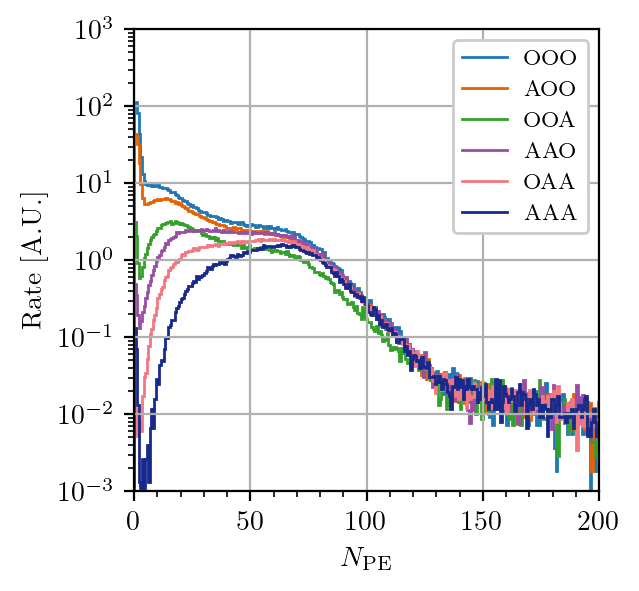

In [45]:
xmin = 0
xmax = 200
nbins = 300
bin_width = (xmax-xmin)/nbins

hist = []
hist_err = []
hist_bins = []
plt.figure(0,figsize=(3,3))
for i,dset in enumerate(ds1117top):
    h,hx = np.histogram(dset.summed_integral_pe, bins=nbins, range=(xmin, xmax))
    herr = np.sqrt(h)
    norm_ = np.sum(h[int((150-xmin)/bin_width):])
    h = h/norm_
    herr = herr/norm_
    hist.append(h)
    hist_err.append(herr)
    hist_bins.append(hx)
    plt.stairs(h,hx,label=coinc[i])
    
plt.yscale('log')
plt.ylabel('Rate [A.U.]')
plt.xlabel(r'$N_{\rm PE}$')
plt.legend(loc='upper right')
plt.xlim(xmin, xmax)
plt.ylim(1e-3,1e3)
plt.minorticks_on()
plt.grid()